In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from util.data_loader import (load_dataset, split_train_validation, 
                              custom_random_oversampling, create_csv_submission,
                              change_negative_class)
from util.features_util import keep_features
from util.features_info import FEATURES_DICT, REPLACEMENT_LIST, FEATURES_BY_CATEGORY
from util.preprocessing import preprocessing_pipeline
from util.custom_pca import CustomPCA
from util.train import reg_logistic_regression
from util.plotting import loss_visualization, decision_threshold
from util.evaluation import evaluation_summary
from util.predict import predict, predict_no_labels
from util.util import init_random_seeds


BASE_PATH = os.path.dirname(os.getcwd()) + "/data"

init_random_seeds()

# Data loading

### ⚠️ Note that the `x_sub` here refers to data for which predictions will be made, but for which we don't have the labels! To refer to the data used for local testing we'll use `x_va` and `y_va` (validation).

In [2]:
# Load data without subsampling
x_train, y_train, x_sub, feature_names = load_dataset(path_x_train=BASE_PATH + "/x_train.csv",
                                                      path_y_train=BASE_PATH + "/y_train.csv",
                                                      path_x_test=BASE_PATH + "/x_test.csv",
                                                      sub_sample=False)
# Create the feature index dictionary
feature_indexes = dict(zip(feature_names, range(len(feature_names))))

# Pre-processing

In [3]:
# Keeping only selected features both in train and validation set
x_train_clean, clean_features, clean_feature_index = keep_features(x_train, FEATURES_DICT.keys(), feature_names, feature_indexes)

Kept 124 features: dict_keys(['GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'POORHLTH', 'PERSDOC2', 'MEDCOST', 'CHECKUP1', '_HCVU651', '_CHOLCHK', '_RFCHOL', 'CVDSTRK3', '_ASTHMS1', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1', '_DRDXAR1', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'DIABAGE2', 'SEX', '_AGE80', 'MARITAL', '_CHLDCNT', '_EDUCAG', '_INCOMG', 'PREGNANT', 'QLACTLM2', 'USEEQUIP', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'HTM4', 'WTKG3', '_BMI5', '_SMOKER3', 'USENOW3', 'DRNKANY5', 'DROCDY3_', '_RFBING5', '_DRNKWEK', '_RFDRHV5', 'FTJUDA1_', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_', 'ORNGDAY_', 'VEGEDA1_', '_FRUTSUM', '_VEGESUM', '_FRTLT1', '_VEGLT1', '_TOTINDA', 'METVL11_', 'METVL21_', 'MAXVO2_', 'ACTIN11_', 'ACTIN21_', 'PADUR1_', 'PADUR2_', 'PAFREQ1_', 'PAFREQ2_', '_MINAC11', '_MINAC21', 'STRFREQ_', 'PA1MIN_', 'PAVIG11_', 'PAVIG21_', 'PA1VIGM_', '_PACAT1', '_PAINDX1', '_PA150R2', '_PA300R2', '_PA30021', '_PASTRNG', 'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 'PREDIAB1', 'INSULIN', 'DOCTDIAB', 'CHKHEMO3', 'FEETCHK'

In [7]:
# Call to the preprocessing pipeline both for train and test set
# NOTE: the preprocessing automatically performs also normalization

x_train_preprocessed = preprocessing_pipeline(x_train_clean, 
                                              where=clean_features,
                                              feature_index=clean_feature_index,
                                              nan_replacement=REPLACEMENT_LIST,
                                              normalize="mixed")

# Translate labels from -1/1 to 0/1
reduced_y_train = change_negative_class(y_train[:, 1], current=-1, new=0)

### PCA exploration

##### For each group of features we plot the correlation matrix. Then we're going to perform PCA on each group of features.

In [8]:
# Plot correlation matrix (2 plot per each row)
for i, category in enumerate(FEATURES_BY_CATEGORY.keys()):
    # Create list of features to keep
    tmp_fs_to_keep = [str(f) for f in FEATURES_BY_CATEGORY[category]]
    
    tmp_x, tmp_features, tmp_feature_index = keep_features(x_train_preprocessed,
                                                           features_to_keep=tmp_fs_to_keep,
                                                           features=clean_features,
                                                           feature_index=clean_feature_index,
                                                           verbose=False)

    if len(tmp_fs_to_keep) > 1:
        # Calculate the correlation matrix using numpy
        fig = plt.figure(figsize=(6, 6))
        ax = plt.gca()
        
        correlation_matrix = np.corrcoef(tmp_x, rowvar=False)
        sns.heatmap(correlation_matrix, annot=False, fmt='.2f', cmap='coolwarm', square=True,
                    xticklabels=tmp_features, yticklabels=tmp_features, ax=ax, vmin=-1, vmax=1)
    
        # Set axis labels and title
        plt.title(category)
        plt.tight_layout()
        plt.savefig(os.path.dirname(os.getcwd()) + "/plots/corr_matrix_{}.png".format(category))
        plt.close(fig)
        

In [11]:
# Perform PCA on each group of features, keeping only the smallest
# number of components that explain 90% of the variance

reduced_x_train = np.empty((x_train_preprocessed.shape[0], 0))

PCA_per_category = {}

for category in FEATURES_BY_CATEGORY.keys():
    
    if len(FEATURES_BY_CATEGORY[category]) > 1:
        # Create the array with data only for the current category
        fs_in_category = [str(f) for f in FEATURES_BY_CATEGORY[category]]
        fs_in_category_indices = [clean_feature_index[feature] for feature in clean_features if feature in fs_in_category]
        category_data = x_train_preprocessed[:, fs_in_category_indices]
        
        # Cerates the PCA object and fit the data
        tmp_pca = CustomPCA()
        tmp_pca.fit(category_data)
        # Save the PCA object so that we can use it later to transform the test data
        PCA_per_category[category] = tmp_pca
        
        # Append the reduced data to the combined matrix
        reduced_data = tmp_pca.transform(category_data, threshold=0.9)
        reduced_x_train = np.concatenate((reduced_x_train, reduced_data), axis=1)
        
        print("Category: {} -> num of PCs for 90% of explained variance: {} over {}".format(
            category, reduced_data.shape[1], category_data.shape[1]))
    else:
        reduced_x_train = np.concatenate((reduced_x_train, x_train_preprocessed[:, clean_feature_index[str(FEATURES_BY_CATEGORY[category][0])]].reshape(-1, 1)), axis=1)


Category: HEALTH_FEATURES -> num of PCs for 90% of explained variance: 3 over 4
Category: HEALTHCARE_FEATURES -> num of PCs for 90% of explained variance: 4 over 4
Category: HYPERTENSION_FEATURES -> num of PCs for 90% of explained variance: 2 over 2
Category: CHRONIC_FEATURES -> num of PCs for 90% of explained variance: 9 over 10
Category: DEMOGRAPHICS_FEATURES -> num of PCs for 90% of explained variance: 12 over 16
Category: TOBACCO_FEATURES -> num of PCs for 90% of explained variance: 2 over 2
Category: ALCOHOL_FEATURES -> num of PCs for 90% of explained variance: 4 over 5
Category: FRUIT_FEATURES -> num of PCs for 90% of explained variance: 7 over 10
Category: EXERCISE_FEATURES -> num of PCs for 90% of explained variance: 11 over 23
Category: IMMUNIZATION -> num of PCs for 90% of explained variance: 2 over 2
Category: DIABETES -> num of PCs for 90% of explained variance: 5 over 6
Category: COGNITIVE_DECLINE -> num of PCs for 90% of explained variance: 2 over 2
Category: ASTHMA -> nu

## Split local data into train and validation

#### From now on we'll use the local train and validation data: `x_tr` and `y_tr` for training and `x_va` and `y_va` for validation

In [12]:
# Split local data into train and validation
(x_tr, x_va, y_tr, y_va) = split_train_validation(reduced_x_train,
                                                  reduced_y_train,
                                                  valid_proportion=0.2)

## Data preparation for training

In [14]:
# NO OVERSAMPLING

# Add bias column to the training and validation data
x_tr_bias = np.append(x_tr, np.ones(shape=(x_tr.shape[0], 1)), axis=1)
x_va_bias = np.append(x_va, np.ones(shape=(x_va.shape[0], 1)), axis=1)


# Training

In [15]:
w, train_loss, valid_loss = reg_logistic_regression(x_tr_bias,
                                                    y_tr,
                                                    x_va_bias,
                                                    y_va,
                                                    lambda_=0.0001, 
                                                    max_iter=5000,
                                                    gamma=0.5,
                                                    batch_size=10000, 
                                                    w=np.random.random(size=x_tr_bias.shape[1]),
                                                    all_losses=True)


Iteration 0/5000 -> lowest loss inf
Iteration 200/5000 -> lowest loss 0.2288491023892846
Iteration 400/5000 -> lowest loss 0.22639843434225623
Iteration 600/5000 -> lowest loss 0.2255617973307588
Iteration 800/5000 -> lowest loss 0.2248241105652168
Iteration 1000/5000 -> lowest loss 0.22417129905304467
Iteration 1200/5000 -> lowest loss 0.2233667177691754
Iteration 1400/5000 -> lowest loss 0.22296486090233755
Iteration 1600/5000 -> lowest loss 0.22233286984837008
Iteration 1800/5000 -> lowest loss 0.22197385873274753
Iteration 2000/5000 -> lowest loss 0.22159751585441717
Iteration 2200/5000 -> lowest loss 0.22121326134975494
Iteration 2400/5000 -> lowest loss 0.22112283249802003
Iteration 2600/5000 -> lowest loss 0.22110178522107354
Iteration 2800/5000 -> lowest loss 0.2210590382630563
Iteration 3000/5000 -> lowest loss 0.2210590382630563
Iteration 3200/5000 -> lowest loss 0.2210590382630563
Iteration 3400/5000 -> lowest loss 0.2210590382630563
Iteration 3600/5000 -> lowest loss 0.2210

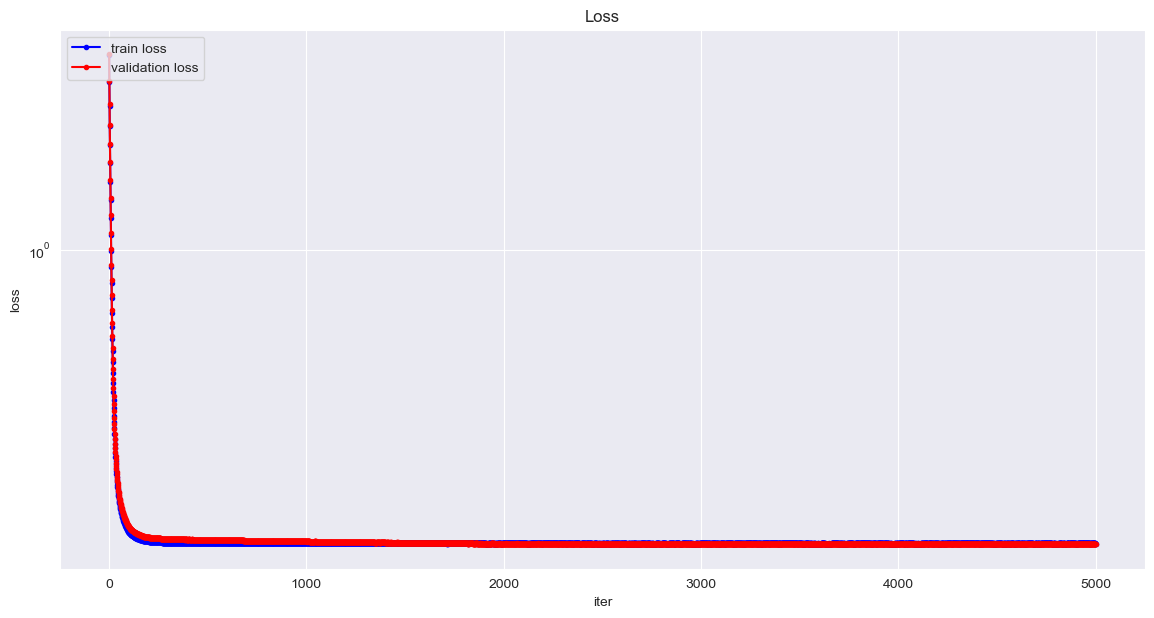

In [16]:
# plot losses
loss_visualization(train_loss, valid_loss)
plt.yscale("log")

# Evaluation on validation set

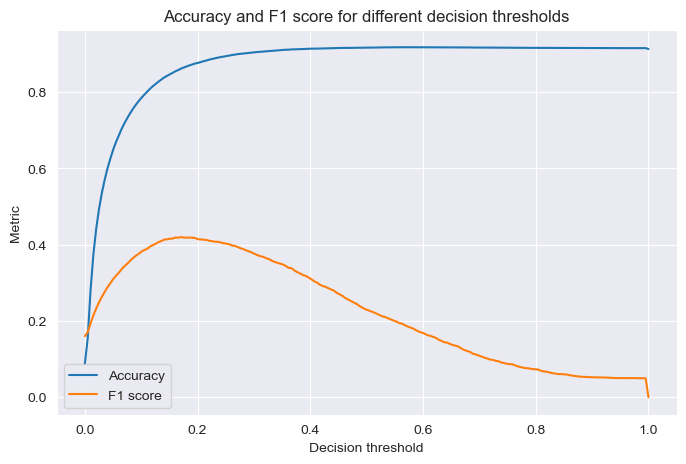

EVALUATION SUMMARY ON VALIDATION SET
Accuracy: 86.17%
Precision: 33.07%
Recall: 57.51%
F1-score: 42.00%


In [17]:
threshold_opt = decision_threshold(x_va_bias, w, y_va)

predicted_y_va = predict(x_va_bias,
                         w,
                         threshold=threshold_opt,
                         negative_label=0)
print("EVALUATION SUMMARY ON VALIDATION SET")
evaluation_summary(y_va, predicted_y_va)

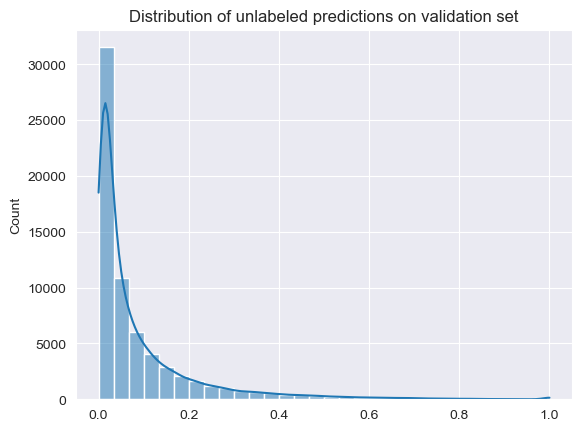

In [18]:
sns.histplot(predict_no_labels(x_va_bias, w), bins=30, kde=True)
plt.title("Distribution of unlabeled predictions on validation set")
plt.show()